## Model: Delta


In [1]:
import pandas as pd
import pandas_profiling

df = pd.read_csv('data/model_data_final_Delta.csv')
df.profile_report()

In [2]:
df = pd.get_dummies(df, columns=['origin', 'destination'])
df.head()

,month,day_of_month,day_of_week,departure_time,delayed,origin_ORD,destination_ATL,destination_CVG,destination_DTW,destination_JFK,destination_LGA,destination_MEM,destination_MSP,destination_SEA,destination_SLC
0,1,10,2,12,1,1,0,0,1,0,0,0,0,0,0
1,1,1,5,5,0,1,1,0,0,0,0,0,0,0,0
2,1,1,5,6,0,1,1,0,0,0,0,0,0,0,0
3,1,1,5,12,0,1,1,0,0,0,0,0,0,0,0
4,1,1,5,15,0,1,1,0,0,0,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('delayed', axis=1), df['delayed'], test_size=0.2, random_state=42)

In [4]:
train_x.shape

(57252, 14)

In [5]:
test_x.shape

(14314, 14)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [7]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.7555540030739136

In [8]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [9]:
roc_auc_score(test_y, probabilities[:, 1])

0.6095255421594399

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[10315,  1116],
       [ 2383,   500]])

In [11]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9115316029324351

In [12]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.7959342560553633

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

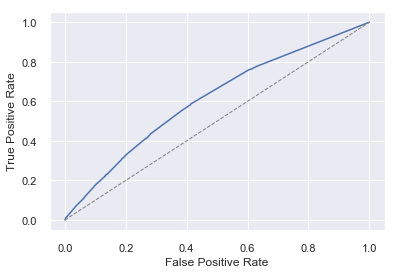

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [15]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%m/%d/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{  'month': month,
                'day': day,
                'day_of_week': day_of_week,
                'departure_time': hour,
                'origin_ORD': 1 if origin == 'ORD' else 0,
                'destination_ATL' : 1 if destination == 'ATL' else 0,
                'destination_CVG' : 1 if destination == 'CVG' else 0,
                'destination_DTW' : 1 if destination == 'DTW' else 0,
                'destination_JFK' : 1 if destination == 'JFK' else 0,
                'destination_LGA' : 1 if destination == 'LGA' else 0,
                'destination_MEM' : 1 if destination == 'MEM' else 0,
                'destination_MSP' : 1 if destination == 'MSP' else 0,
                'destination_SEA' : 1 if destination == 'SEA' else 0,
                'destination_SLC' : 1 if destination == 'SLC' else 0 }]
                
    return model.predict_proba(pd.DataFrame(input))[0][0]

In [16]:
predict_delay('9/1/2018 10:45:00', 'ORD', 'ATL')

1.0

In [17]:
predict_delay('9/2/2018 10:45:00', 'ORD', 'ATL')

1.0

(0.0, 1.0)

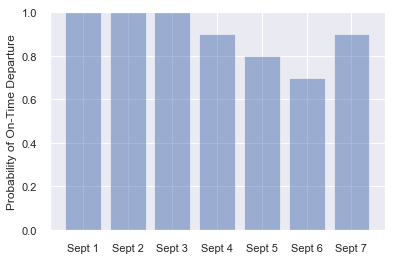

In [18]:
import numpy as np

labels = ('Sept 1', 'Sept 2', 'Sept 3', 'Sept 4', 'Sept 5', 'Sept 6', 'Sept 7')
values = (predict_delay('9/1/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/2/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/3/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/4/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/5/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/6/2019 10:45:00', 'ORD', 'LGA'),
          predict_delay('9/7/2019 10:45:00', 'ORD', 'LGA'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Departure')
plt.ylim((0.0, 1.0))